# Auto Feature Selection
- What model combinations can be used to find the ideal features to model a time series with and also to make the best forecasts?  
- See [Auto Model Specification with ML Techniques for Time Series](https://towardsdatascience.com/auto-model-specification-with-ml-techniques-for-time-series-e7b9a90ae9d7)  

In [1]:
import pandas as pd
import numpy as np
from scalecast.Forecaster import Forecaster
from scalecast.util import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

Diagram to demonstrate the [auto_Xvar_select()](https://scalecast.readthedocs.io/en/latest/Forecaster/Forecaster.html#src.scalecast.Forecaster.Forecaster.auto_Xvar_select) method:


![](./diagram.jpg)

## Use 50 Random Series from M4 Hourly

In [2]:
models = (
    'mlr',
    'elasticnet',
    'gbt',
    'knn',
    'svr',
    'mlp',
)

Hourly = pd.read_csv(
    'Hourly-train.csv',
    index_col=0,
).sample(50)

Hourly_test = pd.read_csv(
    'Hourly-test.csv',
    index_col=0,
)
Hourly_test = Hourly_test.loc[Hourly.index]

info = pd.read_csv(
    'M4-info.csv',
    index_col=0,
    parse_dates=['StartingDate'],
    dayfirst=True,
)

results = pd.DataFrame(
    index = models,
    columns = models,
).fillna(0)

## Run all Model Combos and Evaluate SMAPE

In [3]:
for i in tqdm(Hourly.index):
    y = Hourly.loc[i].dropna()
    sd = info.loc[i,'StartingDate']
    fcst_horizon = info.loc[i,'Horizon']
    cd = pd.date_range(
        start = sd,
        freq = 'H',
        periods = len(y),
    )
    f = Forecaster(
        y = y,
        current_dates = cd,
        future_dates = fcst_horizon,
        test_length = fcst_horizon, # for finding xvars
    )
    # extension of this analysis - take transformations
    for xvm in models:
        for fcstm in models:
            f2 = f.deepcopy()
            f2.auto_Xvar_select(
                estimator = xvm,
                monitor='TestSetRMSE',
                max_ar = 48,
                exclude_seasonalities = ['quarter','month','week','day'],
            )
            f2.set_estimator(fcstm)
            f2.manual_forecast(dynamic_testing=False)
            point_fcst = f2.export('lvl_fcsts')[fcstm]
            results.loc[xvm,fcstm] += metrics.smape(
                Hourly_test.loc[i].dropna().values,
                point_fcst.values,
            )

  0%|          | 0/50 [00:00<?, ?it/s]

## View Results

### SMAPE Combos

In [4]:
results = results / 50
results

,mlr,elasticnet,gbt,knn,svr,mlp
mlr,0.202527,0.326240,0.160442,0.144705,0.267519,0.679007
elasticnet,0.197014,0.299116,0.136523,0.147124,0.269238,0.579156
gbt,0.210620,0.360102,0.171011,0.159181,0.268353,0.740443
knn,0.225529,0.350825,0.165057,0.140396,0.282870,0.707482
svr,0.195592,0.358184,0.151398,0.171485,0.229054,0.785514
mlp,0.216396,0.314216,0.149370,0.149949,0.266556,0.595177


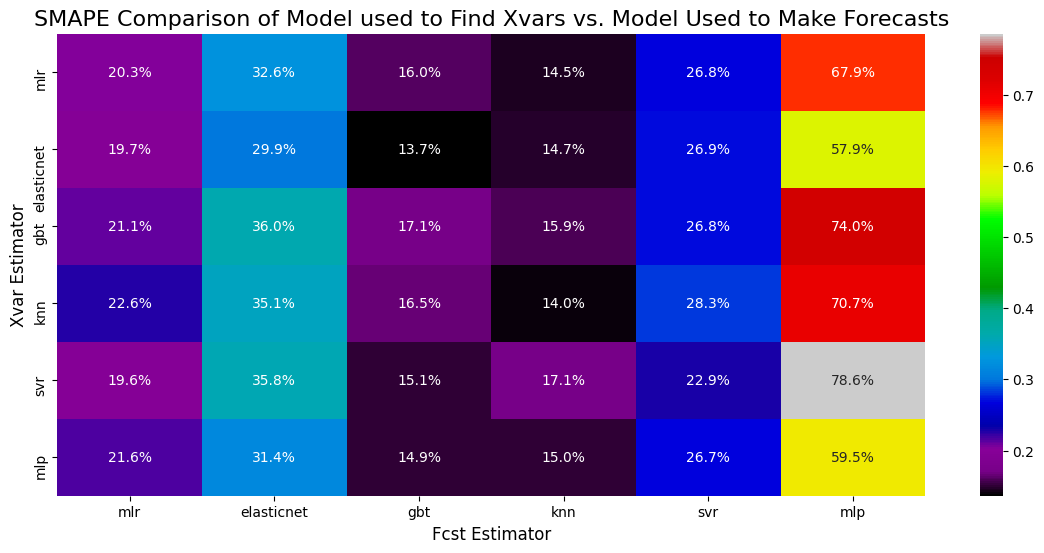

In [5]:
fig, ax = plt.subplots(figsize=(14,6))
sns.heatmap(results,cmap='nipy_spectral',ax=ax,annot=True,fmt='.1%')
plt.ylabel('Xvar Estimator',size=12)
plt.xlabel('Fcst Estimator',size=12)
plt.title('SMAPE Comparison of Model used to Find Xvars vs. Model Used to Make Forecasts',size=16)
plt.show()

### Best Models at Making Forecasts on Average

In [6]:
# Fcst estimators
results.mean().sort_values()

knn           0.152140
gbt           0.155634
mlr           0.207946
svr           0.263932
elasticnet    0.334780
mlp           0.681130
dtype: float64

### Best Models at Finding Xvars on Average

In [7]:
# Xvar estimators
results.mean(axis=1).sort_values()

elasticnet    0.271362
mlp           0.281944
mlr           0.296740
knn           0.312027
svr           0.315204
gbt           0.318285
dtype: float64